In [217]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
import seaborn as sns

In [229]:
# Load in the Data from the CSV that we created
data = pd.read_csv("https://raw.githubusercontent.com/kasterlevi/CSE543_NBA_Project/main/NBA_Player_StatsV2.csv")
data.head()

,Unnamed: 0,Player,Pos,Age,Tm,G,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Season,Target_PTS,Target_TRB,Target_AST
0,0,Kareem Abdul-Jabbar*,C,32.0,LAL,82.0,38.3,10.2,16.9,0.604,...,4.5,1.0,3.4,3.6,2.6,24.8,1980,26.2,10.3,3.4
1,1,Alvan Adams,C,25.0,PHO,75.0,28.9,6.2,11.7,0.531,...,4.3,1.4,0.7,2.9,3.2,14.9,1980,14.9,7.3,4.6
2,2,Tiny Archibald*,PG,31.0,BOS,80.0,35.8,4.8,9.9,0.482,...,8.4,1.3,0.1,3.0,2.7,14.1,1980,13.8,2.2,7.7
3,3,James Bailey,PF,22.0,SEA,67.0,10.8,1.8,4.0,0.450,...,0.4,0.3,0.8,1.2,1.7,4.7,1980,14.0,7.4,1.2
4,4,Greg Ballard,SF,25.0,WSB,82.0,29.7,6.6,13.4,0.495,...,1.9,1.1,0.4,1.6,2.4,15.6,1980,15.5,7.1,2.4


In [219]:
# Remove the categorical data and the target features from the original dataframe
# Encode the 'Pos' feature

target_PTS = data['Target_PTS']
target_TRB = data['Target_TRB']
target_AST = data['Target_AST']
X = data.drop(['Player','Tm','Unnamed: 0', 'Target_PTS','Target_TRB', 'Target_AST', 'Season'], axis=1)
X['Pos'] = X['Pos'].replace({'C': 5, 'PF': 4, 'SF': 3, 'SG': 2, 'PG': 1})

In [220]:
# Split Data into the Same Train and Test Sets 

X_train, X_test, y_train_PTS, y_test_PTS = train_test_split(X, target_PTS, test_size=0.15, random_state=15)
X_train, X_test, y_train_TRB, y_test_TRB = train_test_split(X, target_TRB, test_size=0.15, random_state=15)
X_train, X_test, y_train_AST, y_test_AST = train_test_split(X, target_AST, test_size=0.15, random_state=15)

In [221]:
# Function to help us with choosing the best K-value, includes data scaling and uses Cross Validation on training set 

def choose_k(X, y, n):
    model_values = []
    values = []
    
    kf = KFold(n_splits=10, shuffle = True, random_state=10)
    Xnp = np.array(X)
    ynp = np.array(y)
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train_here, X_val = Xnp[train_idx], Xnp[test_idx]
        y_train_here, y_val = ynp[train_idx], ynp[test_idx]
        scaler = preprocessing.StandardScaler().fit(X_train_here)
        X_train_scaled = scaler.transform(X_train_here)  
        X_val_scaled = scaler.transform(X_val)
    
        model = KNeighborsRegressor(n_neighbors=n)
        model.fit(X_train_scaled, y_train_here)
        predictions = model.predict(X_val_scaled)
        model_values.append(r2_score(y_val, predictions))
    return np.mean(model_values)


In [222]:
# Run the K-means to determine the best number of nearest neighbors for PTS, TRB, and AST

PTS_model_values = []
x_values = range(1,26)
for i in x_values:
    PTS_model_error = choose_k(X_train, y_train_PTS, i)
    PTS_model_values.append(PTS_model_error)

print('here')
TRB_model_values = []
x_values = range(1,26)
for i in x_values:
    TRB_model_error = choose_k(X_train, y_train_TRB, i)
    TRB_model_values.append(TRB_model_error)

print('here')
AST_model_values = []
x_values = range(1,26)
for i in x_values:
    AST_model_error = choose_k(X_train, y_train_AST, i)
    AST_model_values.append(AST_model_error)

here
here


Text(0, 0.5, 'R2 Value')

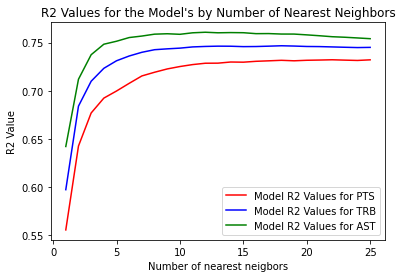

In [223]:
# Plot the R^2 Values for each number

one, = plt.plot(x_values, PTS_model_values, color='red')
two, = plt.plot(x_values, TRB_model_values, color='blue')
three, = plt.plot(x_values, AST_model_values, color='green')
plt.legend((one, two, three), ("Model R2 Values for PTS", "Model R2 Values for TRB", "Model R2 Values for AST"))
plt.title("R2 Values for the Model's by Number of Nearest Neighbors")
plt.xlabel('Number of nearest neigbors')
plt.ylabel('R2 Value')

In [224]:
# Scale the Training Data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test)

# Run PCA to Reduce the amount of features 
pca = PCA(n_components=12, random_state = 8)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [225]:
# Generate the r^2 of the model on the PTS data
model = KNeighborsRegressor(n_neighbors = 15)
model.fit(X_train_pca, y_train_PTS)
predictions = model.predict(X_test_pca)
score_PTS_pca = r2_score(y_test_PTS, predictions)
print('r2 value for predicting PTS: ' + str(score_PTS_pca))
# Compare th Model to if we just used only previous season PTS data
prev_PTS = r2_score(y_test_PTS, X_test['PTS'])
print('r2 value using just previous season PTS data: ' + str(prev_PTS))

# Generate the r^2 of the model for predicting TRB
model = KNeighborsRegressor(n_neighbors = 10)
model.fit(X_train_pca, y_train_TRB)
predictions = model.predict(X_test_pca)
score_TRB_pca = r2_score(y_test_TRB, predictions)
print('r2 value for predicting TRB: ' + str(score_TRB_pca))
# Compare th Model to if we just used only previous season TRB data
prev_TRB = r2_score(y_test_TRB, X_test['TRB'])
print('r2 value using just previous season TRB data: ' + str(prev_TRB))

# Generate the r^2 of the model for predicting AST
model = KNeighborsRegressor(n_neighbors = 10)
model.fit(X_train_pca, y_train_AST)
predictions = model.predict(X_test_pca)
score_AST_pca = r2_score(y_test_AST, predictions)
print('r2 value for predicting PTS: ' + str(score_AST_pca))
# Compare th Model to if we just used only previous season AST data
prev_AST = r2_score(y_test_AST, X_test['AST'])
print('r2 value using just previous season AST data: ' + str(prev_AST))

r2 value for predicting PTS: 0.7323179791403464
r2 value using just previous season PTS data: 0.6998049654525674
r2 value for predicting TRB: 0.7623765889208554
r2 value using just previous season TRB data: 0.7580726690878099
r2 value for predicting PTS: 0.7611965995247287
r2 value using just previous season AST data: 0.7937053260268387


In [226]:
# Generate the r^2 of the model on the PTS data, no PCA
model = KNeighborsRegressor(n_neighbors = 15)
model.fit(X_train_scaled, y_train_PTS)
predictions = model.predict(X_test_scaled)
score_PTS = r2_score(y_test_PTS, predictions)
print('r2 value for predicting PTS: ' + str(score_PTS))

# Generate the r^2 of the model for predicting TRB, no PCA
model = KNeighborsRegressor(n_neighbors = 10)
model.fit(X_train_scaled, y_train_TRB)
predictions = model.predict(X_test_scaled)
score_TRB = r2_score(y_test_TRB, predictions)
print('r2 value for predicting TRB: ' + str(score_TRB))

# Generate the r^2 of the model for predicting AST, no PCA
model = KNeighborsRegressor(n_neighbors = 10)
model.fit(X_train_scaled, y_train_AST)
predictions = model.predict(X_test_scaled)
score_AST = r2_score(y_test_AST, predictions)
print('r2 value for predicting PTS: ' + str(score_AST))

r2 value for predicting PTS: 0.7318408462184851
r2 value for predicting TRB: 0.759396302417443
r2 value for predicting PTS: 0.7751592846552212


Text(0.5, 1.0, 'R^2 Value by Each Statistic and Model Type')

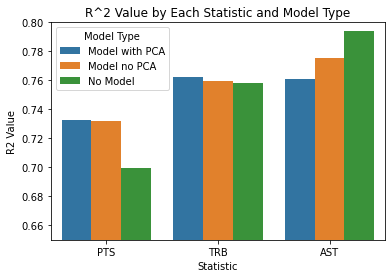

In [227]:
# Create a bar graph Displaying the results for each model type
PTS_values = [score_PTS_pca, score_PTS, prev_PTS]
TRB_values = [score_TRB_pca, score_TRB, prev_TRB]
AST_values = [score_AST_pca, score_AST, prev_AST]
PTS_names = ['Model with PCA', 'Model no PCA','No Model']

graph_df = pd.DataFrame(zip(PTS_names*3, ["PTS"]*3+["TRB"]*3+["AST"]*3, PTS_values+TRB_values+AST_values), columns=["Model Type", "Statistic", "R2 Value"])
# graph_df = pd.DataFrame(data={'PTS': PTS_values, 'TRB': TRB_values, 'AST': AST_values}, index=PTS_names)
sns.barplot(x = "Statistic", y='R2 Value', hue="Model Type", data=graph_df)
plt.ylim(.65,.8)
plt.title('R^2 Value by Each Statistic and Model Type')

In [228]:
# Repeat the whole process multiple times, including doing the split, running PCA, and generating the results
# This is for Predicting Points

r_squared_model = []
r_squared = []
for i in range(10):
    X_train_PTS, X_test_PTS, y_train_PTS, y_test_PTS = train_test_split(X, target_PTS, test_size=0.15)

    scaler = preprocessing.StandardScaler().fit(X_train_PTS)
    X_train_PTS_scaled = scaler.transform(X_train_PTS)  
    X_test_PTS_scaled = scaler.transform(X_test_PTS)

    pca = PCA(n_components=12, random_state = 6)
    pca.fit(X_train_PTS_scaled)
    X_train_pca_current = pca.transform(X_train_PTS_scaled)
    X_test_pca_current = pca.transform(X_test_PTS_scaled)
    
    model = KNeighborsRegressor(n_neighbors=15)
    model.fit(X_train_pca_current, y_train_PTS)
    predictions = model.predict(X_test_pca_current)
    r_squared_model.append(r2_score(y_test_PTS, predictions))
    r_squared.append(r2_score(y_test_PTS, X_test_PTS['PTS']))
print(np.mean(r_squared_model))


0.7379222028395273


In [191]:
# Repeat the whole process multiple times, including doing the split, running PCA, and generating the results
# This is for Predicting Rebounds 

r_squared_model = []
r_squared = []
for i in range(10):
    X_train_TRB, X_test_TRB, y_train_TRB, y_test_TRB = train_test_split(X, target_TRB, test_size=0.15)

    scaler = preprocessing.StandardScaler().fit(X_train_TRB)
    X_train_TRB_scaled = scaler.transform(X_train_TRB)  
    X_test_TRB_scaled = scaler.transform(X_test_TRB)

    pca = PCA(n_components=12, random_state = 6)
    pca.fit(X_train_TRB_scaled)
    X_train_TRB_scaled = pca.transform(X_train_TRB_scaled)
    X_test_TRB_scaled = pca.transform(X_test_TRB_scaled)
    
    model = KNeighborsRegressor(n_neighbors=10)
    model.fit(X_train_TRB_scaled, y_train_TRB)
    predictions = model.predict(X_test_TRB_scaled)
    r_squared_model.append(r2_score(y_test_TRB, predictions))
    r_squared.append(r2_score(y_test_TRB, X_test_TRB['TRB']))
print(np.mean(r_squared_model))
print(np.mean(r_squared))

0.7430018044080013
0.7480205071780393


In [192]:
r_squared_model = []
r_squared = []
for i in range(10):
    X_train_AST, X_test_AST, y_train_AST, y_test_AST = train_test_split(X, target_AST, test_size=0.15)

    scaler = preprocessing.StandardScaler().fit(X_train_AST)
    X_train_AST_scaled = scaler.transform(X_train_AST)  
    X_test_AST_scaled = scaler.transform(X_test_AST)

    pca = PCA(n_components=12, random_state = 6)
    pca.fit(X_train_AST_scaled)
    X_train_AST_scaled = pca.transform(X_train_AST_scaled)
    X_test_AST_scaled = pca.transform(X_test_AST_scaled)
    
    model = KNeighborsRegressor(n_neighbors=17)
    model.fit(X_train_AST_scaled, y_train_AST)
    predictions = model.predict(X_test_AST_scaled)
    r_squared_model.append(r2_score(y_test_AST, predictions))
    r_squared.append(r2_score(y_test_AST, X_test_AST['AST']))
print(np.mean(r_squared_model))
print(np.mean(r_squared))

0.7472473175770806
0.7818163634868948
